In [110]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Correlation
from scipy.stats import chi2_contingency
import seaborn as sns

# PCA
from sklearn.decomposition import PCA

# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score 

# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# fuzzy matching
from thefuzz import process


In [111]:
outfield_df = pd.read_csv("combined_data/outfield_stats.csv")
# print number of rows in outfield_df
print(outfield_df.shape[0])

14696


# Preprocessing

In [112]:
# Parameters
MINUTE_CUT_OFF = 450 # 5 games
FEATURE_IMPORTANT_THRESHOLD = 0.005

Remove duplicates

In [113]:
print(f"Number of outfield player records before dropping duplicates: {len(outfield_df)}")
outfield_df = outfield_df.drop_duplicates()
print(f"Number of outfield player records after dropping duplicates: {len(outfield_df)}")

Number of outfield player records before dropping duplicates: 14696
Number of outfield player records after dropping duplicates: 14696


Visualising and dropping rows where with players that didn't play enough for sample to be representative

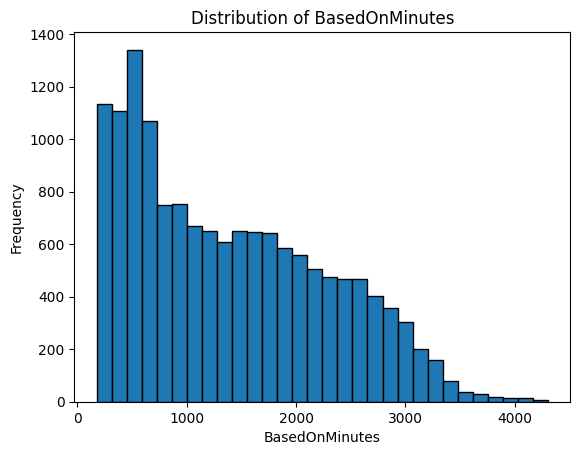

In [114]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

In [115]:
# Dropping all entries with BasedOnMinutes less than MINUTE_CUT_OFF min
print(f"Number of outfield outfield records before filtering: {len(outfield_df)}")
outfield_df = outfield_df[outfield_df['BasedOnMinutes'] >= MINUTE_CUT_OFF]
print(f"Number of outfield outfield records after filtering: {len(outfield_df)}")

Number of outfield outfield records before filtering: 14696
Number of outfield outfield records after filtering: 12567


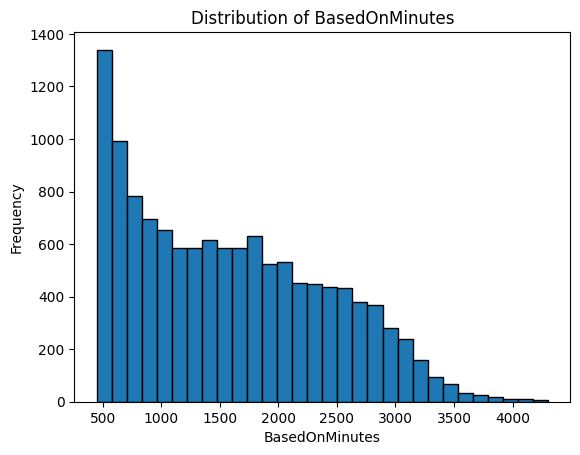

In [116]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

Dropping rows with "Last 365 Days Men's Big 5 Leagues"

In [117]:
# Drop rows where scouting_period is "Last 365 Days Men's Big 5 Leagues"
outfield_df = outfield_df[outfield_df['scouting_period'] != "Last 365 Days Men's Big 5 Leagues"]

Dropping Percentile data 

In [118]:
print(f"Number of outfield player records before dropping Percentile: {outfield_df.shape[1]}")
columns_to_drop = [col for col in outfield_df.columns if 'Percentile' in col]
outfield_df = outfield_df.drop(columns=columns_to_drop)
print(f"Number of outfield player records after dropping Percentile: {outfield_df.shape[1]}")

Number of outfield player records before dropping Percentile: 238
Number of outfield player records after dropping Percentile: 121


Handling na values

In [119]:
null_rows = outfield_df[outfield_df.isnull().any(axis=1)]
null_rows.to_excel('transformed_data/null_rows.xlsx', index=False)

In [120]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 1347


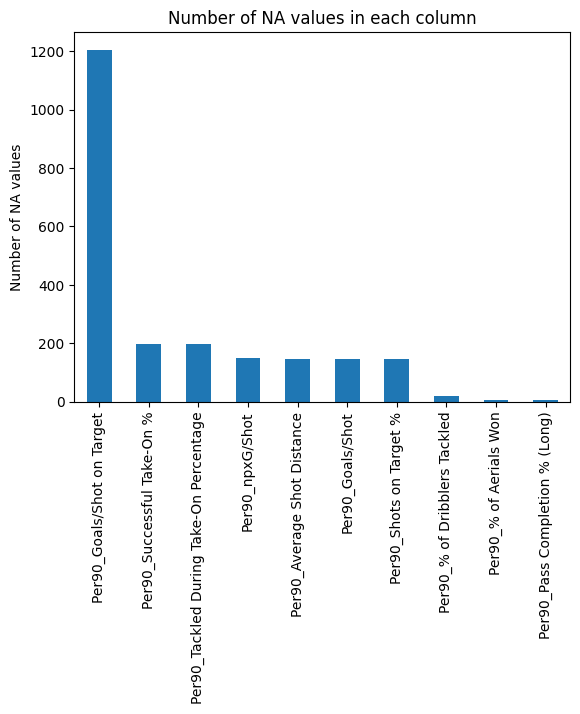

In [121]:
# Visualise columns with na values, sort from highest to lowest
na_columns = outfield_df.isnull().sum()
na_columns = na_columns[na_columns > 0]
na_columns = na_columns.sort_values(ascending=False)
na_columns.plot(kind='bar')
plt.ylabel('Number of NA values')
plt.title('Number of NA values in each column')
plt.show()

In [122]:
# If Per90 is not dropped
na_columns_goal_related_per90 = ['Per90_Goals/Shot on Target', 
                                 'Per90_npxG/Shot', 
                                 'Per90_Average Shot Distance', 
                                 'Per90_Goals/Shot', 
                                 'Per90_Shots on Target %']
na_columns_dribble_related_per90 = ['Per90_Successful Take-On %',
                                    'Per90_Tackled During Take-On Percentage']
na_columns_others = ['Per90_% of Dribblers Tackled',
                    'Per90_% of Aerials Won',
                    'Per90_Pass Completion % (Long)']
def get_existing_columns(df, *column_lists):
    existing_cols = []
    for col_list in column_lists:
        existing_cols.extend([col for col in col_list if col in df.columns])
    return existing_cols

# Get all existing columns from the three lists
existing_columns = get_existing_columns(outfield_df, 
                                        na_columns_goal_related_per90, 
                                        na_columns_dribble_related_per90, 
                                        na_columns_others)

outfield_df[existing_columns] = outfield_df[existing_columns].fillna(0)

In [123]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 0


Combining rows to ensure that one entry is tagged to only one unique player

In [124]:
print(outfield_df.dtypes)

Player                             object
Versus                             object
BasedOnMinutes                      int64
scouting_period                    object
Per90_% of Aerials Won            float64
                                   ...   
Per90_npxG/Shot                   float64
Per90_npxG: Non-Penalty xG        float64
Per90_xA: Expected Assists        float64
Per90_xAG: Exp. Assisted Goals    float64
Per90_xG: Expected Goals          float64
Length: 121, dtype: object


In [125]:
# Drop non-numeric column "scouting_period"
outfield_df = outfield_df.drop(columns=["scouting_period"], errors="ignore")

# Define numeric columns excluding categorical ones
numeric_cols = [col for col in outfield_df.columns if col not in ['Player', 'Versus', 'BasedOnMinutes']]

# Compute weighted averages for numeric stats
weighted_avg_df = outfield_df.groupby("Player").apply(
    lambda group: pd.Series(
        {col: np.average(group[col], weights=group["BasedOnMinutes"]) for col in numeric_cols}
    )
).reset_index()

# Drop "BasedOnMinutes" since it's no longer needed
outfield_df = weighted_avg_df.drop(columns=["BasedOnMinutes"], errors="ignore")

outfield_df.head()

/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_31610/314367980.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg_df = outfield_df.groupby("Player").apply(


,Player,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Assists,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Blocks,Per90_Carries,...,Per90_Touches (Def Pen),Per90_Touches (Live-Ball),Per90_Touches (Mid 3rd),Per90_Yellow Cards,Per90_npxG + xAG,Per90_npxG/Shot,Per90_npxG: Non-Penalty xG,Per90_xA: Expected Assists,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals
0,Aaron Cresswell,53.744897,54.478054,1.050578,1.232776,0.126076,23.713051,5.019973,1.003463,33.071370,...,3.829974,67.727667,31.363400,0.152007,0.151503,0.053259,0.028676,0.105276,0.125962,0.028676
1,Aaron Wan-Bissaka,46.982567,74.928410,1.019510,0.916619,0.080330,15.204835,5.334216,1.442013,31.436534,...,4.094386,66.273364,27.892252,0.126624,0.086534,0.081324,0.025679,0.061230,0.061986,0.025679
2,Aarón Martín,36.244264,50.992465,0.973289,0.585540,0.083322,23.944634,4.585236,0.963194,26.358914,...,2.536466,55.738766,23.858121,0.156446,0.164019,0.045687,0.026725,0.158879,0.140334,0.030512
3,Abakar Sylla,60.826103,78.107119,1.155755,1.817705,0.000000,10.692593,5.070812,1.795272,49.081027,...,11.074247,74.790661,32.954726,0.280075,0.070945,0.119135,0.059902,0.008909,0.015017,0.059902
4,Abdallah Sima,44.736643,55.210985,3.062034,2.557767,0.076327,13.790835,4.024681,0.688130,20.934739,...,1.179373,34.769628,13.939379,0.138356,0.400423,0.129369,0.308988,0.072494,0.091646,0.308988


Merge with age_data

In [126]:

age_df = pd.read_csv("combined_data/age-valuation.csv")

for name in outfield_df['Player']:
    matched_name, score, _ = process.extractOne(name, age_df['Player'])

    if score >= 70:
        outfield_df['Player'] = outfield_df['Player'].replace(name, matched_name)

outfield_df = outfield_df.merge(
    age_df[['Player', 'age']], 
    on="Player", 
    how="left"
)

print(f"Number of na values in Age: {outfield_df['age'].isna().sum()}")
# drop na values
outfield_df = outfield_df.dropna(subset=['age'])
print(f"Number of na values in Age after dropping: {outfield_df['age'].isna().sum()}")

print("Merging completed successfully!")

Number of na values in Age: 71
Number of na values in Age after dropping: 0
Merging completed successfully!


Load the valuations_df

In [134]:
valuations_df = pd.read_csv("combined_data/age-valuation.csv")

Log the distribution of player market value

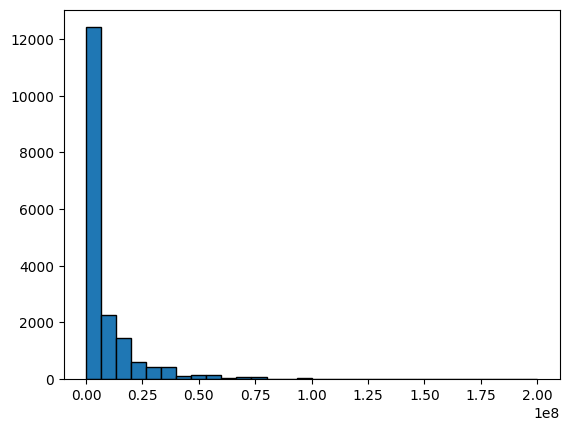

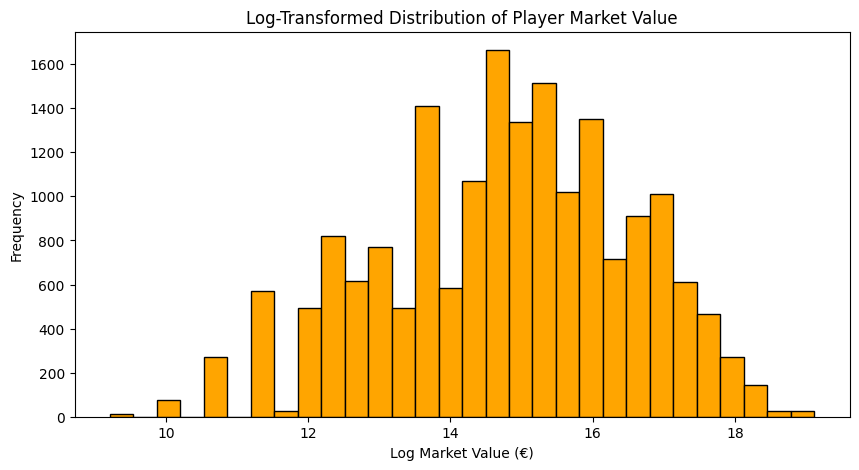

In [131]:

# visualise distribution of player market value
plt.hist(valuations_df['player_market_value_euro'], bins=30, edgecolor='k')

# log visualisation
log_values = np.log1p(valuations_df['player_market_value_euro'])  # log(1 + x) to avoid log(0) issues

# Log visualisation
plt.figure(figsize=(10, 5))
plt.hist(log_values, bins=30, edgecolor='k', color='orange')
plt.xlabel('Log Market Value (€)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Player Market Value')
plt.show()

# convert player_market_value to a log scale
valuations_df['player_market_value_euro'] = np.log(valuations_df['player_market_value_euro'])


Merge data with valuation

In [135]:

# Filter only rows where season_start_year is 2024
valuations_2024_df = valuations_df[valuations_df['season_start_year'] == 2024]

# Change 'Player' value in outfield_df to that in valuations_2024_df if fuzzy matching
for name in outfield_df['Player']:
    matched_name, score, _ = process.extractOne(name, valuations_2024_df['Player'])

    if score >= 70:
        # replace name with best_match
        outfield_df['Player'] = outfield_df['Player'].replace(name, matched_name)

# Merge only player_market_value_euro for 2024 season
outfield_df = outfield_df.merge(
    valuations_2024_df[['Player', 'player_market_value_euro']], 
    on="Player", 
    how="left"
)

# Print number of na values in player_market_value_euro
print(f"Number of na values in player_market_value_euro: {outfield_df['player_market_value_euro'].isna().sum()}")
# drop na values
outfield_df = outfield_df.dropna(subset=['player_market_value_euro'])
print(f"Number of na values in player_market_value_euro after dropping: {outfield_df['player_market_value_euro'].isna().sum()}")

Number of na values in player_market_value_euro: 231
Number of na values in player_market_value_euro after dropping: 0


Feature Engineering

In [136]:
# Compute the Goals per Expected Goals Ratio
outfield_df["Finishing_Efficiency"] = outfield_df["Per90_Goals"] / outfield_df["Per90_Goals - xG"]

# Handle cases where xG is zero (avoid division by zero)
outfield_df["Finishing_Efficiency"].fillna(0, inplace=True)
outfield_df["Finishing_Efficiency"] = outfield_df["Finishing_Efficiency"].replace(np.inf, 0)

# Drop Per90_Goals - xG
outfield_df = outfield_df.drop(columns=["Per90_Goals - xG"])

# Compute the Assists per Expected Assists Ratio
outfield_df["Assist_Efficiency"] = outfield_df["Per90_Assists"] / outfield_df["Per90_xA: Expected Assists"]
outfield_df["Assist_Efficiency"].fillna(0, inplace=True)
outfield_df["Assist_Efficiency"] = outfield_df["Assist_Efficiency"].replace(np.inf, 0)
outfield_df = outfield_df.drop(columns=["Per90_xA: Expected Assists"])

# Compute Shot Efficiency (Goals per Shot)
outfield_df["Shot_Efficiency"] = outfield_df["Per90_Goals"] / outfield_df["Per90_Shots Total"]
outfield_df["Shot_Efficiency"].fillna(0, inplace=True)
outfield_df["Shot_Efficiency"] = outfield_df["Shot_Efficiency"].replace(np.inf, 0)
outfield_df.drop(columns=["Per90_Shots Total"], inplace=True)

# Compute Passing Efficiency (Pass Completion Ratio)
outfield_df["Pass_Efficiency"] = outfield_df["Per90_Passes Completed"] / outfield_df["Per90_Passes Attempted"]
outfield_df["Pass_Efficiency"].fillna(0, inplace=True)
outfield_df["Pass_Efficiency"] = outfield_df["Pass_Efficiency"].replace(np.inf, 0)
outfield_df.drop(columns=["Per90_Passes Attempted", "Per90_Passes Completed"], inplace=True)

# Compute Possession Lost Ratio (Dispossessed + Miscontrols per Touch)
outfield_df["Possession_Lost_Ratio"] = (outfield_df["Per90_Dispossessed"] + outfield_df["Per90_Miscontrols"]) / outfield_df["Per90_Touches"]
outfield_df["Possession_Lost_Ratio"].fillna(0, inplace=True)
outfield_df["Possession_Lost_Ratio"] = outfield_df["Possession_Lost_Ratio"].replace(np.inf, 0)

# Compute Progressive Play Contribution (Progressive Carries + Progressive Passes)
outfield_df["Progressive_Play"] = outfield_df["Per90_Progressive Carries"] + outfield_df["Per90_Progressive Passes"]

# Compute Ball Retention Ability (Successful Take-Ons / Take-On Attempts)
outfield_df["Ball_Retention"] = outfield_df["Per90_Successful Take-Ons"] / outfield_df["Per90_Take-Ons Attempted"]
outfield_df["Ball_Retention"].fillna(0, inplace=True)
outfield_df["Ball_Retention"] = outfield_df["Ball_Retention"].replace(np.inf, 0)
outfield_df.drop(columns=["Per90_Take-Ons Attempted", "Per90_Successful Take-Ons"], inplace=True)

# Compute Set-Piece Involvement (Total Contribution from Set-Pieces)
outfield_df["Set_Piece_Involvement"] = (
    outfield_df["Per90_Corner Kicks"] +
    outfield_df["Per90_Passes from Free Kicks"] +
    outfield_df["Per90_Penalty Kicks Attempted"]
)
outfield_df.drop(columns=["Per90_Corner Kicks", "Per90_Passes from Free Kicks", "Per90_Penalty Kicks Attempted"], inplace=True)


/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_31610/1732614726.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  outfield_df["Finishing_Efficiency"].fillna(0, inplace=True)
/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_31610/1732614726.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

Investigate feature importance

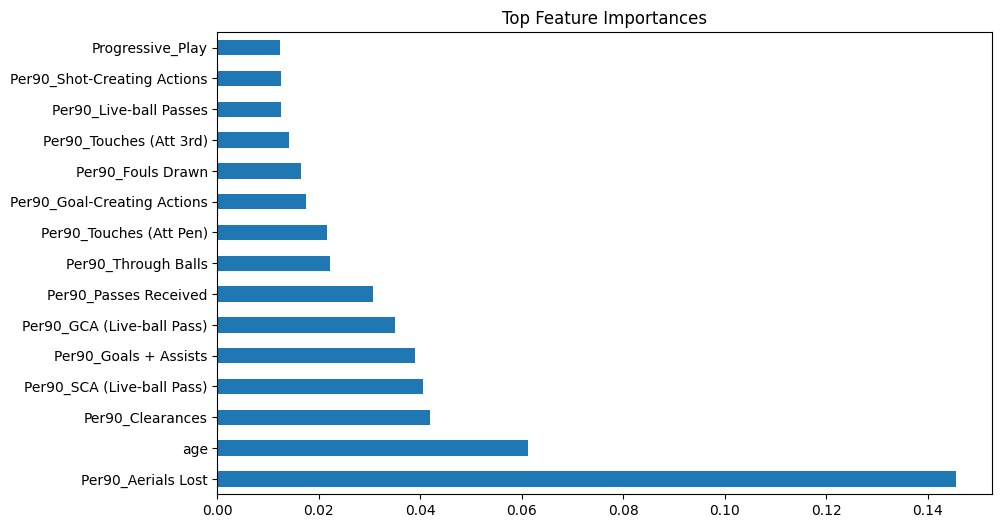

In [137]:
from sklearn.ensemble import RandomForestRegressor

# Define features and target
X = outfield_df.drop(columns=["player_market_value_euro", "Player"])  # Features
y = outfield_df["player_market_value_euro"]  # Target

# Train a simple model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Plot feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(15).plot(kind='barh', figsize=(10, 6), title="Top Feature Importances")
plt.show()

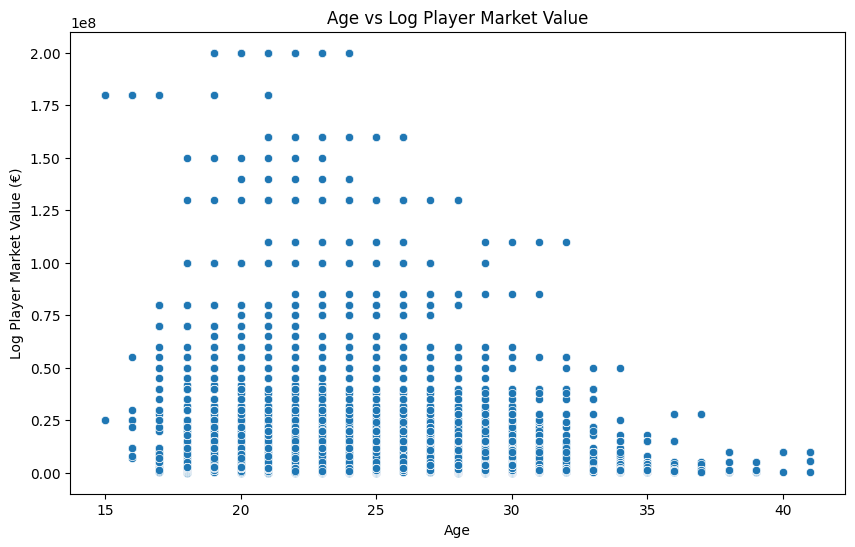

/Users/ruicong/My Drive (kwanruicong6462@gmail.com)/professional/SMU/academic/dap/deadline-day/.direnv/python-3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Age vs Player Market Value')

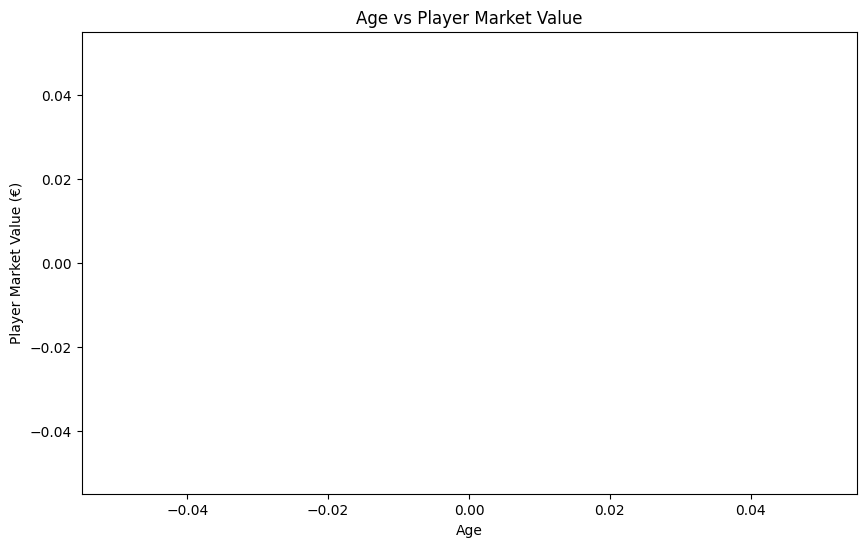

In [138]:
# Visualise age against player_market_value_euro
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outfield_df['age'], y=outfield_df['player_market_value_euro'])
plt.xlabel('Age')
plt.ylabel('Log Player Market Value (€)')
plt.title('Age vs Log Player Market Value')
plt.show()

# Visualise as un-logged valuation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outfield_df['age'], y=np.exp(outfield_df['player_market_value_euro']))
plt.xlabel('Age')
plt.ylabel('Player Market Value (€)')
plt.title('Age vs Player Market Value')

Drop features with low importance and based on domain knowledge

In [139]:
# Identify features to drop (importance < 0.01)
drop_features = feature_importance[feature_importance < FEATURE_IMPORTANT_THRESHOLD].index

# Debugging Step: Print features to be dropped
print(f"Dropping {len(drop_features)} features due to low importance.\n")

# Ensure only numerical columns are dropped in the main dataset
common_columns_to_drop = [col for col in drop_features if col in outfield_df.columns]

# Drop features from both X and outfield_df
X = X.drop(columns=drop_features)
outfield_df = outfield_df.drop(columns=common_columns_to_drop)

print(f"Number of features after dropping non-important features: {X.shape[1]}")

Dropping 63 features due to low importance.

Number of features after dropping non-important features: 53


Standardise numerical features

In [140]:
scaler = StandardScaler()
statistical_cols = [col for col in outfield_df.columns if col not in ['Player', 'player_market_value_euro']]
outfield_df[statistical_cols] = scaler.fit_transform(outfield_df[statistical_cols])

Finding correlation between features 

In [141]:
# Function to compute Cramér's V
def cramers_v(cat_variable, num_variable):
    contingency_table = pd.crosstab(outfield_df[cat_variable], pd.qcut(outfield_df[num_variable], q=4))
    chi2 = chi2_contingency(contingency_table)[0]
    n = outfield_df.shape[0]
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Identify categorical and numerical columns
categorical_cols = []
non_numeric_cols = ["Player", "player_market_value_euro"] + categorical_cols
numerical_cols = outfield_df.select_dtypes(include=["float64", "int64"]).columns

# Drop non-numeric variables before computing numerical correlations
numerical_df = outfield_df.drop(columns=non_numeric_cols, errors="ignore")

# Compute Pearson correlation for numerical variables
numerical_corr_matrix = numerical_df.corr()

# Initialize Cramér’s V matrix for categorical-numerical correlations
cramers_matrix = pd.DataFrame(index=categorical_cols, columns=numerical_cols)

# Compute Cramér's V for categorical-numerical relationships
for cat_col in categorical_cols:
    for num_col in numerical_cols:
        if cat_col != num_col:
            cramers_matrix.loc[cat_col, num_col] = cramers_v(cat_col, num_col)

# Convert Cramér’s V values to float
cramers_matrix = cramers_matrix.astype(float)

# Merge Pearson correlation with Cramér’s V correlation
full_correlation_matrix = numerical_corr_matrix.copy()

for cat_col in categorical_cols:
    for num_col in numerical_cols:
        full_correlation_matrix.loc[cat_col, num_col] = cramers_matrix.loc[cat_col, num_col]

# Convert final matrix to float for heatmap
full_correlation_matrix = full_correlation_matrix.astype(float)


In [142]:
# Set correlation threshold 
correlation_threshold = 0.9

# Compute the absolute correlation matrix
corr_matrix = full_correlation_matrix.abs()

# Create a set to hold the features to remove
features_to_remove = set()

# Iterate through correlation matrix and identify features to drop
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > correlation_threshold:  # If correlation is above threshold
            colname = corr_matrix.columns[i]  # Get feature name
            features_to_remove.add(colname)  # Add it to the removal list

# Drop the identified features
outfield_df_reduced = outfield_df.drop(columns=features_to_remove, errors="ignore")

# Save the cleaned dataset
outfield_df_reduced.to_csv("transformed_data/outfield_stats_cleaned.csv", index=False)

print(f"Removed {len(features_to_remove)} highly correlated features.")
print(f"Remaining features: {outfield_df_reduced.shape[1]}")
print(f"Reminding columns: {outfield_df_reduced.columns}")

Removed 6 highly correlated features.
Remaining features: 49
Reminding columns: Index(['Player', 'Per90_% of Aerials Won', 'Per90_% of Dribblers Tackled',
       'Per90_Aerials Lost', 'Per90_Aerials Won',
       'Per90_Average Shot Distance', 'Per90_Ball Recoveries', 'Per90_Blocks',
       'Per90_Carries', 'Per90_Carries into Final Third', 'Per90_Clearances',
       'Per90_Dead-ball Passes', 'Per90_Dispossessed', 'Per90_Errors',
       'Per90_Fouls Committed', 'Per90_Fouls Drawn',
       'Per90_GCA (Dead-ball Pass)', 'Per90_GCA (Live-ball Pass)',
       'Per90_GCA (Shot)', 'Per90_Goals + Assists',
       'Per90_Goals/Shot on Target', 'Per90_Interceptions',
       'Per90_Non-Penalty Goals - npxG', 'Per90_Pass Completion % (Long)',
       'Per90_Pass Completion % (Medium)', 'Per90_Pass Completion % (Short)',
       'Per90_Passes Attempted (Long)', 'Per90_Passes Attempted (Short)',
       'Per90_Penalty Kicks Won', 'Per90_Progressive Passes Rec',
       'Per90_SCA (Live-ball Pass)', 'Per9

In [143]:
# Save the processed file
outfield_df.to_csv("preprocessed_data/outfield_processed.csv", index=False)
print("Merging completed successfully!")

Merging completed successfully!


In [144]:
outfield_df.head()

,Player,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Blocks,Per90_Carries,Per90_Carries into Final Third,...,Per90_Yellow Cards,Per90_npxG/Shot,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals,age,player_market_value_euro,Finishing_Efficiency,Pass_Efficiency,Progressive_Play,Set_Piece_Involvement
0,Aaron Cresswell,0.618902,0.571541,-0.455175,-0.145304,1.392601,0.201346,-0.204539,0.121574,-0.151957,...,-0.576698,-1.018567,0.351185,-0.809431,0.999217,700000.0,0.06327,-0.283535,0.424347,1.671318
1,Aaron Cresswell,0.618902,0.571541,-0.455175,-0.145304,1.392601,0.201346,-0.204539,0.121574,-0.151957,...,-0.576698,-1.018567,0.351185,-0.809431,1.232938,700000.0,0.06327,-0.283535,0.424347,1.671318
2,Aaron Cresswell,0.618902,0.571541,-0.455175,-0.145304,1.392601,0.201346,-0.204539,0.121574,-0.151957,...,-0.576698,-1.018567,0.351185,-0.809431,1.466659,700000.0,0.06327,-0.283535,0.424347,1.671318
3,Aaron Cresswell,0.618902,0.571541,-0.455175,-0.145304,1.392601,0.201346,-0.204539,0.121574,-0.151957,...,-0.576698,-1.018567,0.351185,-0.809431,1.700381,700000.0,0.06327,-0.283535,0.424347,1.671318
4,Aaron Cresswell,0.618902,0.571541,-0.455175,-0.145304,1.392601,0.201346,-0.204539,0.121574,-0.151957,...,-0.576698,-1.018567,0.351185,-0.809431,1.934102,700000.0,0.06327,-0.283535,0.424347,1.671318


Dropping highly-correlated data

In [145]:
# top_3_features = ['Player','age', 'Per90_Pass Completion % (Short)', 'Per90_Pass Completion % (Long)', 'Per90_GCA (Live-ball Pass)', 'Per90_Carries', 'Per90_Pass Completion %', 'Finishing_Efficiency']
# outfield_df = outfield_df_reduced[top_3_features]

Reducing Dimension

In [146]:
# # Specify categorical columns to keep
# non_statistical_data = ["Player"]  

# # Separate categorical and numerical features
# kept_features_df = outfield_df[non_statistical_data].reset_index(drop=True)  # Reset index for safe merge
# features = outfield_df.drop(columns=non_statistical_data)  # Drop categorical columns for PCA

# # Print the number of features before PCA
# print("Number of features before PCA:", features.shape[1])

# # Apply PCA to retain 95% variance
# pca = PCA(n_components=0.95)
# X_pca = pca.fit_transform(X_scaled)

# # Convert PCA output back to DataFrame
# pca_df = pd.DataFrame(X_pca, index=outfield_df.index)

# # # Name PCA columns properly
# # pca_df.columns = [f'PCA_{i+1}' for i in range(pca_df.shape[1])]

# # Concatenate categorical columns with PCA-transformed numerical data
# outfield_df = pd.concat([kept_features_df, pca_df.reset_index(drop=True)], axis=1)

# # Print the number of features after PCA
# print("Number of features after PCA:", pca_df.shape[1])

# # Plot PCA explained variance
# plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title("PCA Explained Variance")
# plt.show()

Encoding Categorical Variables (all categorical were dropped as we are manually separating by position)

In [147]:
# print("Columns before encoding:", outfield_df.columns)
# outfield_df = pd.get_dummies(outfield_df, columns=['Versus', 'scouting_period'])
# print("Columns after encoding:", outfield_df.columns)

Others (Removing outliers)